This resource is intended to be a good place for beginners to get started with RL in a practical way and is basically a summary of the [RL course by David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html). To obtain more information about the concepts here discussed please check the course!

We'll implement the tasks described at the [Easy 21 assignment](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf).


Special thanks to:
  * David Silver for the great RL course
  * [AnalogRL implementation's of easy21](https://github.com/analog-rl/Easy21) which had great graphs including the
  gif generation you see in this notebook.


## TODO: intro to RL

Talk about: Agents, Environment, Policy, How it learns, ...

## Rules of the Easy 21 game

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

## Dependencies

First let's import all the depedencies to run the code.

In [42]:
# TODO: add header

# vectors manipulation
import numpy as np

# plotting stuff
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# basically visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# generating random values
import random

# representing things like card value or colors
from enum import Enum  

# copying python objects
import copy

## Plot code

The code bellow is used to generate the different plots you'll se in the following sections, not an important section, skip it if you want to.

In [59]:
def plot_value_function(agent, title='Value Function', generate_gif=False):
    '''
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just seeing the graph for the value function (no training)
    or to train as you go and generate a gif of the training.

    args:
        V (tensor): value function (tensor)
        generate_gif (boolean): if want to save steps as a gif
        title (string): plot title
        train_steps (int): number of step to train when generating a gif
    '''
    # you can change this values to change the size of the graph
    fig = plt.figure(title, figsize=(10, 5))
    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')
  
    V = agent.get_value_function()

    def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
        min_x = 1
        max_x = V.shape[0]
        min_y = 1
        max_y = V.shape[1]

        # creates a sequence from min to max
        x_range = np.arange(min_x, max_x)
        y_range = np.arange(min_y, max_y)

        # creates a grid representation of x_range and y_range
        X, Y = np.meshgrid(x_range, y_range)

        # get value function for X and Y values
        def get_stat_val(x, y):
            return V[x, y]
        Z = get_stat_val(X, Y)

        # creates a surface to be ploted
        # check documentation for details: https://goo.gl/etEhPP
        ax.set_xlabel('Daler Showing')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Value')
        return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)

    def animate(frame):
        ax.clear()
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train live
        if generate_gif:
            i = agent.iterations
            step_size = min(max(1, agent.iterations), 2 ** 16)
            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
            # plt.draw()
        else:
            plt.title(title)
        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()


## Task 1 : Game Implementation (Environment)

You should write an environment that implements the game Easy21.

Specifically, write a **function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s (which may be terminal if the game is finished) and reward r.**

We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1).

You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

Then apply Monte-Carlo control to Easy21.

### Deck

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game

In [41]:
class Color(Enum):
    RED = 0
    BLACK = 1
    def __int__(self):
        return self.value

class Card(object):
        
    def __init__(self, color=None):
        self.value = self._get_random_value()
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            self.color = self._get_random_color()

    def _get_random_value(self):
        '''
            Generates integers between 1 and 10.
        '''
        return random.randint(1, 10)
    
    def _get_random_color(self):
        '''
            Generates random colors.
            Color.RED with 1/3 and Color.BLACK with 2/3 probability.
        '''
        random_number = random.random()
        if random_number <= 1/3.0:
            return Color.RED
        else:
            return Color.BLACK


class Deck(object):  
    def __init__(self):
        return
    
    def get_card(self, color=None):
        return Card(color)

### State and Action

The state is defined by the dealers cards and the agent cards.

In [43]:
class State(object):
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal

class Action(Enum):
    STICK = 0
    HIT = 1

### Dealer

* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [44]:
class Player(object):
    def __init__(self):
        pass

    def policy(self, s):
        '''Given a state and a deck of cards available choose an action'''
        action = None
        return action


class Dealer(Player):
    def __init__(self):
        Player.__init__(self)

    def policy(self, s):
        if s.dealer_sum >= 17:
            return Action.STICK
        else:
            return Action.HIT

### Environment (Game)

* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)


In [45]:
class Environment(object):
    def __init__(self):
        self.dealer = Dealer()
        self.deck = Deck()
        
        self.player_max_value = 21  # max value a player gets during the game
        self.dealer_max_value = 10  # max value the dealer gets duting the game
        self.actions_count = 2  # number of possible actions
    
    def _check_bust(self, player_sum):
        return player_sum <= 1 or player_sum > 21
    
    def _get_reward_no_bust(self, s):
        if s.agent_sum > s.dealer_sum:
            return 1
        elif s.agent_sum == s.dealer_sum:
            return 0
        else:
            return -1

    def get_card(self, card_color=None):
        Card = self.deck.get_card(card_color)
        if Card.color == Color.BLACK:
            return Card.value
        else:
            return -1 * Card.value

    def dealer_turn(self, s):
        action = None
        while not s.is_terminal and action != Action.STICK:
            action = self.dealer.policy(s)
            if action == Action.HIT:
                s.dealer_sum += self.get_card() 
            s.is_terminal = self._check_bust(s.dealer_sum)
        return s
    
    def initial_state(self):
        # first set sums to 0
        s = State()
        
        # then the agent and dealer get a black card
        s.agent_sum += self.get_card(Color.BLACK)
        s.dealer_sum += self.get_card(Color.BLACK)
        
        return s

    def step(self, s, a):
        '''
            Given a state and an action return the next state.
            
            Args:
                s (State): current state
                a (Action): action chosen by player
            return:
                next_s (State): next state
                r (Integer): reward [-1, 0, 1]
        '''
        
        r = 0
        next_s = copy.copy(s)

        if a == Action.STICK:
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1
            else:
                next_s.is_terminal = True
                r = self._get_reward_no_bust(next_s)       
        else:
            next_s.agent_sum += self.get_card(self.deck)
            next_s.is_terminal = self._check_bust(next_s.agent_sum)

            # if end of the game then player lost: reward = -1
            if next_s.is_terminal:
                r = -1
        
        # print next_s.dealer_sum, next_s.agent_sum, next_s.is_terminal
        return next_s, r

In [61]:
class MC_Q_function(object):
    
    def __init__(self, dealers_sum, agent_sum, num_actions):
        self.q = np.zeros([dealers_sum, agent_sum, num_actions])

    def get_best_action_state(self, state):
        return self.get_best_action(state.dealer_sum, state.agent_sum)
    
    def get_best_action(self, d_sum, a_sum):
        return Action.HIT if np.argmax(self.q[d_sum][a_sum]) == 1 else Action.STICK

    def get_max_action(self, d_sum, a_sum):
        return np.max(self.q[d_sum][a_sum])

    def predict_state(self, alpha, state, action, Gt):
        d_sum = state.dealer_sum
        a_sum = state.agent_sum
        error = Gt - self.q[d_sum][a_sum][action.value]
        self.q[d_sum][a_sum][action.value] += alpha * error

class MC_agent(Player):
    
    def __init__(self, environment, No=100, discount_factor=1):
        
        Player.__init__(self)
        # easy21 environment
        self.env = environment
        # we can tune this parameter
        self.No = No
        # we can tune this parameter
        self.disc_factor = discount_factor
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = MC_Q_function(self.env.dealer_max_value + 1,
                            self.env.player_max_value + 1, 
                            self.env.actions_count)
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_max_value + 1,
                           self.env.player_max_value + 1, 
                           self.env.actions_count))
        
        # V(s) is the state value function. How good is to be at state s?
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.player_max_value + 1])
        
        self.wins = 0
        self.iterations = 0
        
    def get_alpha(self, st, at):
        '''αt = 1/N(st, at)'''
        # print st.dealer_sum, st.agent_sum, at.value
        return 1.0/(self.N[st.dealer_sum][st.agent_sum][at.value])
    
    def get_e(self, st):
        '''et = N0/(N0 + N(st))'''
        # print st.dealer_sum, st.agent_sum, st.is_terminal
        return self.No/((self.No + sum(self.N[st.dealer_sum, st.agent_sum, :]) * 1.0))
    
    def get_value_function(self):
        '''Get best value function in the moment.'''
        for i in xrange(self.env.dealer_max_value):
            for j in xrange(self.env.player_max_value):
                self.V[i][j] = self.Q.get_max_action(i, j)
        return self.V
    
    def get_random_action(self):
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def policy(self, s):
        r = random.random()
        #print r, self.get_e(s)
        if r <= self.get_e(s):
            action = self.get_random_action()
        else:
            action = self.Q.get_best_action_state(s)

        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action
        '''
        if self.value_sum >= 17:
            return Action.STICK
        else:
            self.get_card(deck)
            return Action.HIT
        '''
    
    def predict(self, episode):
        '''Given an episode. Improve the value function approximation.'''
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            Gt = sum([x[2]*(self.disc_factor**i) for i,x in enumerate(episode[j:])])
            # print '*', j, Gt
            self.Q.predict_state(self.get_alpha(s, a), s, a, Gt)
            j += 1
            '''
            self.returns_sum[d_sum][a_sum] += G
            self.V[d_sum][a_sum] = self.returns_sum[d_sum][a_sum] / self.N_s[d_sum][a_sum]
            ''' 
    
    def train(self, steps):
        for e in xrange(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            # while game has not ended
            while not s.is_terminal:
                
                # get action with epsilon greedy policy
                a = self.policy(s)
                
                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # update state
                s = next_s

            if e % 10000 == 0 and self.iterations > 0:
                print "Episode: %d, score: %d" % (e, float(self.wins)/(self.iterations*100))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1
                
            # Update Action value function accordingly
            self.predict(episode) 

        # Derive value function
        return self.get_value_function()

Episode: 10000, score: 49
Episode: 20000, score: 50
Episode: 30000, score: 51
Episode: 40000, score: 51
Episode: 50000, score: 51
Episode: 60000, score: 52
Episode: 70000, score: 52
Episode: 80000, score: 52
Episode: 90000, score: 52
Episode: 0, score: 52
Episode: 10000, score: 52
Episode: 20000, score: 53
Episode: 30000, score: 53
Episode: 40000, score: 53
Episode: 50000, score: 53
Episode: 60000, score: 53
Episode: 70000, score: 53
Episode: 80000, score: 53
Episode: 90000, score: 53
Episode: 0, score: 53
Episode: 10000, score: 53
Episode: 20000, score: 53
Episode: 30000, score: 53
Episode: 40000, score: 53
Episode: 50000, score: 53
Episode: 60000, score: 53
Episode: 70000, score: 53
Episode: 80000, score: 53
Episode: 90000, score: 53
Episode: 0, score: 53
Episode: 10000, score: 53
Episode: 20000, score: 53
Episode: 30000, score: 53
Episode: 40000, score: 53
Episode: 50000, score: 53
Episode: 60000, score: 53
Episode: 70000, score: 53
Episode: 80000, score: 53
Episode: 90000, score: 5

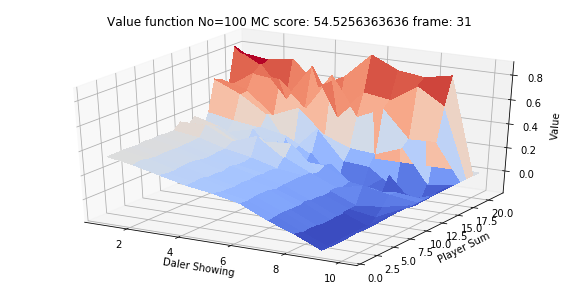

In [57]:
environment = Environment()
agent = MC_agent(environment)

plot_value_function(agent.get_value_function(), generate_gif=True, title="Value function No=100")

Episode: 0, score: 0
Episode: 0, score: 0
Episode: 0, score: 25
Episode: 0, score: 37
Episode: 0, score: 37
Episode: 0, score: 40
Episode: 0, score: 48
Episode: 0, score: 50
Episode: 0, score: 48
Episode: 0, score: 47
Episode: 0, score: 47
Episode: 0, score: 45
Episode: 0, score: 46
Episode: 0, score: 45
Episode: 0, score: 45
Episode: 10000, score: 45
Episode: 0, score: 45
Episode: 10000, score: 45
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 40000, score: 46
Episode: 50000, score: 46
Episode: 60000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 46
Episode: 30000, score: 46
Episode: 40000, score: 46
Episode: 50000, score: 46
Episode: 60000, score: 46
Episode: 0, score: 46
Episode: 10000, score: 46
Episode: 20000, score: 47
Episode: 30000, score: 47
Episode: 40000, score: 47
Episode: 50000, score: 47
Episode: 60000, score: 47
Episode: 0, 

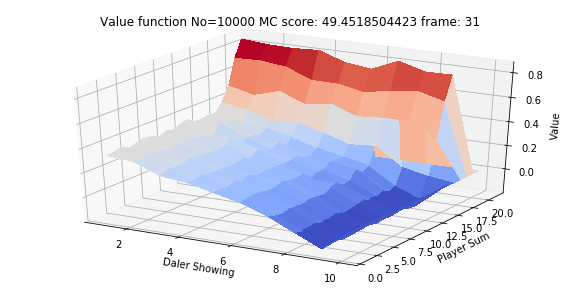

In [60]:
environment = Environment()
agent = MC_agent(environment, No=10000)

plot_value_function(agent, generate_gif=True, title="Value function No=10000")

0 0 0.0
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
0 5 0.0
0 6 0.0
0 7 0.0
0 8 0.0
0 9 0.0
0 10 0.0
0 11 0.0
0 12 0.0
0 13 0.0
0 14 0.0
0 15 0.0
0 16 0.0
0 17 0.0
0 18 0.0
0 19 0.0
0 20 0.0
1 0 0.0
1 1 0.341215746279
1 2 0.349349583968
1 3 0.346948037214
1 4 0.36703539823
1 5 0.337813333333
1 6 0.359451937487
1 7 0.337047939445
1 8 0.351708237267
1 9 0.350680786687
1 10 0.347619988149
1 11 0.353333333333
1 12 0.342786246012
1 13 0.35632183908
1 14 0.388980263158
1 15 0.368518518519
1 16 0.349576271186
1 17 0.402712264151
1 18 0.575957727873
1 19 0.720538720539
1 20 0.853741496599
2 0 0.0
2 1 0.311701081613
2 2 0.320281008868
2 3 0.313886157544
2 4 0.312389380531
2 5 0.310775862069
2 6 0.323708694257
2 7 0.310496083551
2 8 0.299697275479
2 9 0.311348781937
2 10 0.308536098923
2 11 0.305135951662
2 12 0.311395912712
2 13 0.32746074301
2 14 0.302918207974
2 15 0.33179297597
2 16 0.299232736573
2 17 0.387961859356
2 18 0.574237288136
2 19 0.707717569787
2 20 0.845303867403
3 0 0.0
3 1 0.232892143058


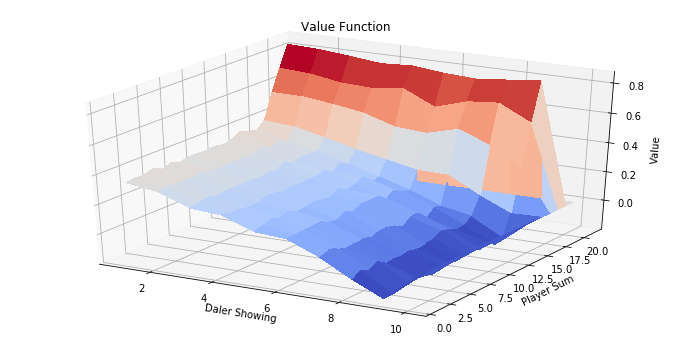

In [38]:
plot_value_function(agent.get_value_function())

0 0 0.0
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
0 5 0.0
0 6 0.0
0 7 0.0
0 8 0.0
0 9 0.0
0 10 0.0
0 11 0.0
0 12 0.0
0 13 0.0
0 14 0.0
0 15 0.0
0 16 0.0
0 17 0.0
0 18 0.0
0 19 0.0
0 20 0.0
1 0 0.0
1 1 0.342218884926
1 2 0.355974842767
1 3 0.346200980392
1 4 0.369850746269
1 5 0.348910101154
1 6 0.36216839677
1 7 0.333798492883
1 8 0.355657876378
1 9 0.349615436513
1 10 0.345546263109
1 11 0.342128408091
1 12 0.341384115188
1 13 0.362704918033
1 14 0.388043478261
1 15 0.379724055189
1 16 0.334725121781
1 17 0.378048780488
1 18 0.589947089947
1 19 0.715217391304
1 20 0.855093256815
2 0 0.0
2 1 0.316170861937
2 2 0.319981369353
2 3 0.322500365979
2 4 0.31328320802
2 5 0.310464110695
2 6 0.316173316173
2 7 0.310023967292
2 8 0.303939962477
2 9 0.318296404405
2 10 0.303547612697
2 11 0.294271972016
2 12 0.317073170732
2 13 0.323559150657
2 14 0.31170212766
2 15 0.343693962941
2 16 0.297082228117
2 17 0.375384615385
2 18 0.576888888889
2 19 0.705521472393
2 20 0.827489481066
3 0 0.0
3 1 0.241929358147

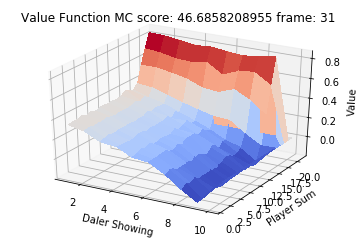

In [34]:
plot_value_function(agent.get_value_function(), is_gif=True)

In [ ]:
plt.show()

In [ ]:

fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

def plot_frame(ax, V):
    def get_stat_val(x, y):
        return V[x, y]

    min_x = 1
    max_x = V.shape[0]
    
    min_y = 1
    max_y = V.shape[1]

    # this creates a sequence from min to max
    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)
    
    # this creates a grid representation of x_range and y_range
    X, Y = np.meshgrid(x_range, y_range)
    Z = get_stat_val(X, Y)
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    return surf

def animate(frame):
    ax.clear()
    surf = plot_frame(ax, agent.get_value_function())
    # plt.title('MC score:%s frame:%s' % (float(agent.wins)/agent.iterations*100, frame))
    # plt.draw()
    fig.canvas.draw()
    # print "done ", frame, step_size, i
    return surf

ani = animation.FuncAnimation(fig, animate, 32, repeat=False)



# note: requires gif writer; swap with plt.show()
#ani.save('MC_Agent.gif', writer='imagemagick', fps=3)
plt.show()
pu.plot_value_function(agent.get_value_function())

In [ ]:

agent = Agent(1000000)
environment = Environment()

MAX = 500000
for i in xrange(MAX):
    environment.run_episode(agent)
    if i % 1000 == 0:
        print '%d/%d' % (i, MAX)

plot_value_function(agent.get_value_function(), is_gif=True)

In [ ]:
plot_value_function(agent.get_value_function())

## TD Learning

In [62]:
class TD_Q_function(object):
    
    def __init__(self, dealers_sum, agent_sum, num_actions):
        self.q = np.zeros([dealers_sum, agent_sum, num_actions])

    def get_best_action_state(self, state):
        return self.get_best_action(state.dealer_sum, state.agent_sum)
    
    def get_best_action(self, d_sum, a_sum):
        return Action.HIT if np.argmax(self.q[d_sum][a_sum]) == 1 else Action.STICK

    def get_max_action(self, d_sum, a_sum):
        return np.max(self.q[d_sum][a_sum])

    def get(self, s, a):
        return np[s.dealer_sum][s.agent_sum][a.value]
    
    def update(self, s, a, value):
        self.q[s.dealer_sum][s.agent_summ][a.value] = value
    
    def update_state(s, a, next_s, next_a, r, alpha, dis_factor):
        error = disc_factor * self.get(next_s, next_a) - self.get(s, a)
        update(s, a, self.get(s, a) + alpha * (r + error))

class TD_agent(Player):
    
    def __init__(self, environment, No=100, discount_factor=1):
        
        Player.__init__(self)
        # easy21 environment
        self.env = environment
        # we can tune this parameter
        self.No = No
        # we can tune this parameter
        self.disc_factor = discount_factor
        
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = MC_Q_function(self.env.dealer_max_value + 1,
                            self.env.player_max_value + 1, 
                            self.env.actions_count)
        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = np.zeros((self.env.dealer_max_value + 1,
                           self.env.player_max_value + 1, 
                           self.env.actions_count))
        
        # V(s) is the state value function. How good is to be at state s?
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.player_max_value + 1])
        
        self.wins = 0
        self.iterations = 0
        
    def get_alpha(self, st, at):
        '''αt = 1/N(st, at)'''
        # print st.dealer_sum, st.agent_sum, at.value
        return 1.0/(self.N[st.dealer_sum][st.agent_sum][at.value])
    
    def get_e(self, st):
        '''et = N0/(N0 + N(st))'''
        # print st.dealer_sum, st.agent_sum, st.is_terminal
        return self.No/((self.No + sum(self.N[st.dealer_sum, st.agent_sum, :]) * 1.0))
    
    def get_value_function(self):
        '''Get best value function in the moment.'''
        for i in xrange(self.env.dealer_max_value):
            for j in xrange(self.env.player_max_value):
                self.V[i][j] = self.Q.get_max_action(i, j)
        return self.V
    
    def get_random_action(self):
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def policy(self, s):
        r = random.random()
        #print r, self.get_e(s)
        if r <= self.get_e(s):
            action = self.get_random_action()
        else:
            action = self.Q.get_best_action_state(s)

        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action
        '''
        if self.value_sum >= 17:
            return Action.STICK
        else:
            self.get_card(deck)
            return Action.HIT
        '''
    
    def train(self, steps):
        for e in xrange(steps):
            episode = []
            
            # get initial state for current episode
            s = self.env.initial_state()
            
            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            
            # while game has not ended
            while not s.is_terminal:

                # execute action
                next_s, r = self.env.step(copy.copy(s), a)
                
                # store action state and reward
                episode.append((s, a, r))
                
                # get action with epsilon greedy policy
                next_a = self.policy(next_s)
                
                self.Q.update_state(s, a, next_s, next_a, r, self.get_alpha(s, a))
                
                # update state and action
                s = next_s
                a = next_a

            if e % 10000 == 0 and self.iterations > 0:
                print "Episode: %d, score: %d" % (e, float(self.wins)/(self.iterations*100))
            
            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1
                
            # Update Action value function accordingly
            self.predict(episode) 

        # Derive value function
        return self.get_value_function()